In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/city_temperature_monthly.csv')

In [3]:
df.head()

,Date_By_Month,Month,Day,Year,AvgTemperature,RefTemperature,Temp_Anomaly
0,1995-01-01,1,1,1995,6.822478,6.822478,0.0
1,1995-02-01,2,1,1995,8.023549,8.023549,0.0
2,1995-03-01,3,1,1995,11.269077,11.269077,0.0
3,1995-04-01,4,1,1995,14.446167,14.446167,0.0
4,1995-05-01,5,1,1995,18.561886,18.561886,0.0


Since 1995 is the reference year, the temperature anomaly (Temp_Anomaly) values for 1995 would all be zero, and so we can exclude all rows in the year 1995 from our data analysis.

In [4]:
#Remove all data in 1995.
df = df[df.Year != 1995]
df.head()

,Date_By_Month,Month,Day,Year,AvgTemperature,RefTemperature,Temp_Anomaly
12,1996-01-01,1,1,1996,5.558924,6.822478,-1.263554
13,1996-02-01,2,1,1996,7.216812,8.023549,-0.806737
14,1996-03-01,3,1,1996,9.431285,11.269077,-1.837792
15,1996-04-01,4,1,1996,14.576168,14.446167,0.130000
16,1996-05-01,5,1,1996,18.814664,18.561886,0.252778


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 288 entries, 12 to 299
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date_By_Month   288 non-null    object 
 1   Month           288 non-null    int64  
 2   Day             288 non-null    int64  
 3   Year            288 non-null    int64  
 4   AvgTemperature  288 non-null    float64
 5   RefTemperature  288 non-null    float64
 6   Temp_Anomaly    288 non-null    float64
dtypes: float64(3), int64(3), object(1)
memory usage: 18.0+ KB


In [6]:
#Set datetime as index
df.set_index('Date_By_Month', inplace=True)
df.index = pd.to_datetime(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 1996-01-01 to 2019-12-01
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Month           288 non-null    int64  
 1   Day             288 non-null    int64  
 2   Year            288 non-null    int64  
 3   AvgTemperature  288 non-null    float64
 4   RefTemperature  288 non-null    float64
 5   Temp_Anomaly    288 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 15.8 KB


We ultimately want to forecast the Temp_Anomaly data such that we can find out when the 1.5 temperature threshold set by the 2015 Paris Agreement will be exceeded.

In [7]:
#Set Temp_Anomaly as the predictor variable
y = df.Temp_Anomaly
type(y)

pandas.core.series.Series

In [8]:
y.describe()

count    288.000000
mean       0.616489
std        0.898157
min       -1.837792
25%        0.009970
50%        0.644366
75%        1.117099
max        4.166303
Name: Temp_Anomaly, dtype: float64

<AxesSubplot:xlabel='Date_By_Month'>

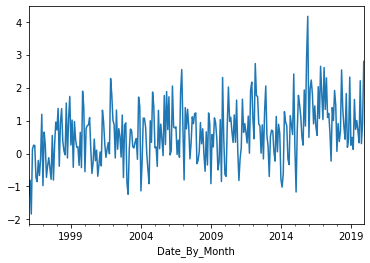

In [9]:
#Plot time series
y.plot()

The data appears to be a bit fluctuated, and so we can use the rolling mean of 12 months (1 year) to smooth out our data.

In [10]:
months_rolled = 12
y_rolled = y.rolling(window=months_rolled).mean()
y_rolled

Date_By_Month
1996-01-01         NaN
1996-02-01         NaN
1996-03-01         NaN
1996-04-01         NaN
1996-05-01         NaN
                ...   
2019-08-01    0.834961
2019-09-01    0.867192
2019-10-01    0.876540
2019-11-01    0.915247
2019-12-01    0.954982
Name: Temp_Anomaly, Length: 288, dtype: float64

In [11]:
y_rolled.dropna(inplace=True)
y_rolled

Date_By_Month
1996-12-01   -0.390714
1997-01-01   -0.366684
1997-02-01   -0.245327
1997-03-01   -0.069755
1997-04-01   -0.140871
                ...   
2019-08-01    0.834961
2019-09-01    0.867192
2019-10-01    0.876540
2019-11-01    0.915247
2019-12-01    0.954982
Name: Temp_Anomaly, Length: 277, dtype: float64

<AxesSubplot:xlabel='Date_By_Month'>

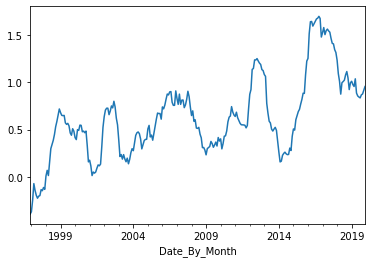

In [12]:
y_rolled.plot()

**Decomposition**

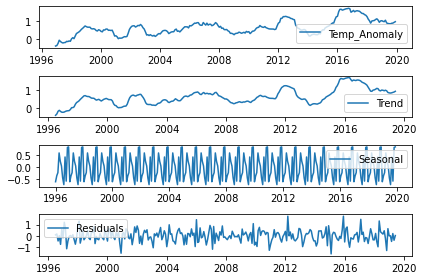

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Assign decomposed values
decomposition = seasonal_decompose(y) 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the original data, trend, seasonality, and residuals 
plt.subplot(411)
plt.plot(y_rolled, label = 'Temp_Anomaly')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc = 'best')
plt.tight_layout()

Overall, we can see an increasing trend for the temperature anomaly, which make sense given global warming causing the average temperature to rise over the years.

**Stationarity Test**

We ideally want the time series to be stationary, and so we check for stationarity using the KPSS test.

In [14]:
#Test for stationarity
from statsmodels.tsa.stattools import kpss
kpss(y_rolled, nlags="auto")

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(1.2669259346442614,
 0.01,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

P-value is smaller than 0.05, so the null hypothesis is rejected and we conclude that the data is non-stationary.

As such, we need to take steps to transform the data to make the time series become stationary.

<AxesSubplot:xlabel='Date_By_Month'>

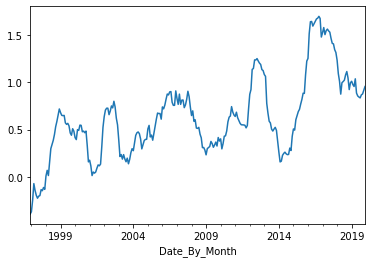

In [15]:
y_rolled.plot()

We can create constant variance by taking the natural log of all values in the dataset.

<AxesSubplot:xlabel='Date_By_Month'>

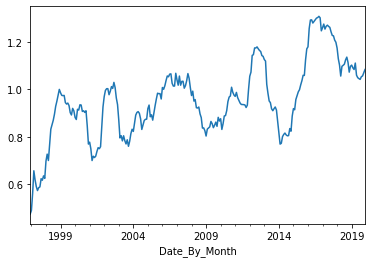

In [16]:
#Constant variance with .log()

#From the plot above, we can see that there are values of zero for temperature anomaly.
#We add 2 to the data in order to avoid taking the log of any zero values.
y_log = np.log(y_rolled+2)
y_log.plot()

We can also create constant mean by differencing our data.

<AxesSubplot:xlabel='Date_By_Month'>

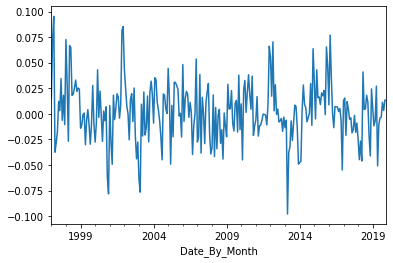

In [17]:
#Constant mean with .diff()
y_log.diff().dropna().plot()

In [18]:
#Test for stationarity once again
kpss(y_log.diff().dropna(), nlags="auto")

/Users/alex/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.10000753437954374,
 0.1,
 7,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

P-value is now 0.1 (>0.05), and so we can accept the null hypothesis that the data is stationary.

**Modelling**

We will be using the ARIMA model for the time series analysis and forecasting.

The most common evaluation metrics for time series are RMSE (root mean squared error), MAPE (mean absolute percentage error), and MAE (mean absolute error). As such, we will be using those as our evaluation metrics to determine the best order for our ARIMA model.

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA

In [20]:
# Find RMSE of an ARIMA model 
def eval_rmse(data, arima_order):
    split = int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]
    pred = list()
    
    for i in range(len(test)):
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        pred.append(future)
        past.append(test[i])
    
    error = mean_squared_error(test, pred, squared=False)
    return error

In [21]:
#Find MAPE of an ARIMA model
def eval_mape(data, order):
    split = int(len(data) * 0.8)
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]
    pred = list()
    
    for i in range(len(test)): 
        model = ARIMA(past, order=order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        pred.append(future)
        past.append(test[i])
    
    error = mean_absolute_percentage_error(test, pred)
    return error

In [22]:
#Find MAE of an ARIMA model
def eval_mae(data, order):
    split = int(len(data) * 0.8)
    train, test = data[0:split], data[split:len(data)]
    past = [x for x in train]
    pred = list()
    
    for i in range(len(test)): 
        model = ARIMA(past, order=order)
        model_fit = model.fit(disp=0)
        future = model_fit.forecast()[0]
        pred.append(future)
        past.append(test[i])
    
    error = mean_absolute_error(test, pred)
    return error

In [23]:
# Evaluate ARIMA models with various orders of p, d, and q values.
def evaluate_models(data, p_values, d_values, q_values):
    best_rmse, best_rmse_order = float("inf"), None
    best_mape, best_mape_order = float("inf"), None
    best_mae, best_mae_order = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = eval_rmse(data, order)
                    mape = eval_mape(data, order)
                    mae = eval_mae(data, order)
                    if rmse < best_rmse:
                        best_rmse, best_rmse_order = rmse, order
                    if mape < best_mape:
                        best_mape, best_mape_order = mape, order
                    if mae < best_mae:
                        best_mae, best_mae_order = mae, order
                    print('ARIMA%s RMSE=%.5f MAPE=%.5f MAE=%.5f' % (order, rmse, mape, mae))
                except:
                    continue
    
    print('Best ARIMA (by RMSE) %s RMSE=%.5f' % (best_rmse_order, best_rmse))
    print('Best ARIMA (by MAPE) %s MAPE=%.5f' % (best_mape_order, best_mape))
    print('Best ARIMA (by MAE) %s MAE=%.5f' % (best_mae_order, best_mae))

In [24]:
#Set the range of the orders, 0 to 2 for all p,d,q values
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

In [25]:
#Use the evaluation metrics to find the best ARIMA model

import warnings
warnings.filterwarnings("ignore")
#evaluate_models(y_log, p_values, d_values, q_values)

The best ARIMA model according to RMSE, MAPE, and MAE is (2,1,2), and so we use ARIMA(2,1,2) for our modelling.

In [26]:
model = ARIMA(y_log, order=(2,1,2))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Temp_Anomaly   No. Observations:                  276
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 603.895
Method:                       css-mle   S.D. of innovations              0.027
Date:                Fri, 04 Feb 2022   AIC                          -1195.790
Time:                        00:41:15   BIC                          -1174.068
Sample:                    01-01-1997   HQIC                         -1187.074
                         - 12-01-2019                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0025      0.002      1.021      0.307      -0.002       0.007
ar.L1.D.Temp_Anomaly     1.7856      0.073     24.310      0.000       1.642       1.930
ar.L2.D.Temp_Anomaly    -0.8688      0.076    -11.471      0.000      -1.017      -0.720
ma.L1.D.Temp_Anomaly    -1.6656      0.099    -16.823      0.000      -1.860      -1.472
ma.L2.D.Temp_Anomaly     0.7907      0.110      7.196      0.000       0.575       1.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0276           -0.3082j            1.0728           -0.0464
AR.2            1.0276           +0.3082j            1.0728            0.0464
MA.1            1.0533           -0.3942j            1.1246           -0.0570
MA.2            1.0533           +0.3942j            1.1246            0.0570
-----------------------------------------------------------------------------
"""

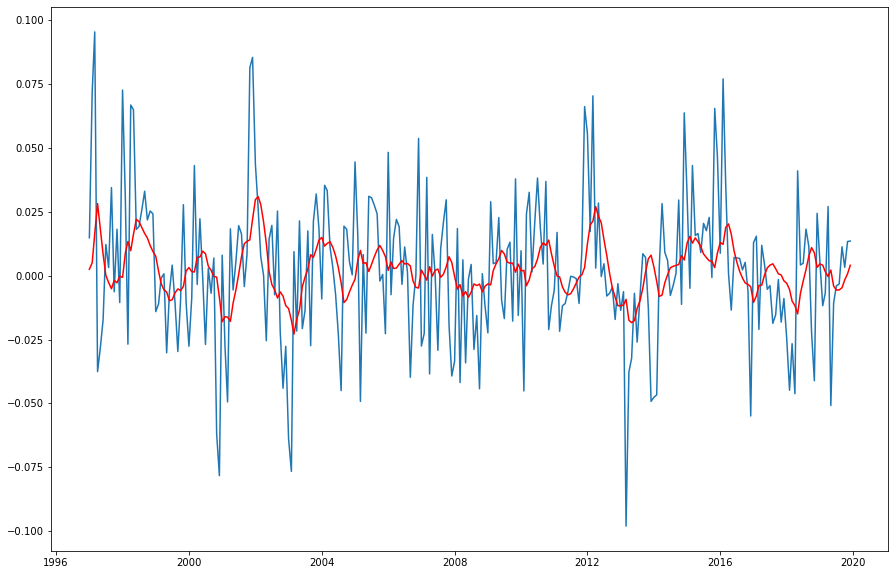

In [27]:
#Comparison of the model with the original data

plt.figure(figsize=(15,10))
plt.plot(y_log.diff())
plt.plot(model_fit.predict(), color = 'red')

We can see that the model (red line) follows pretty closely to the original data (blue line).

**Forecasting**

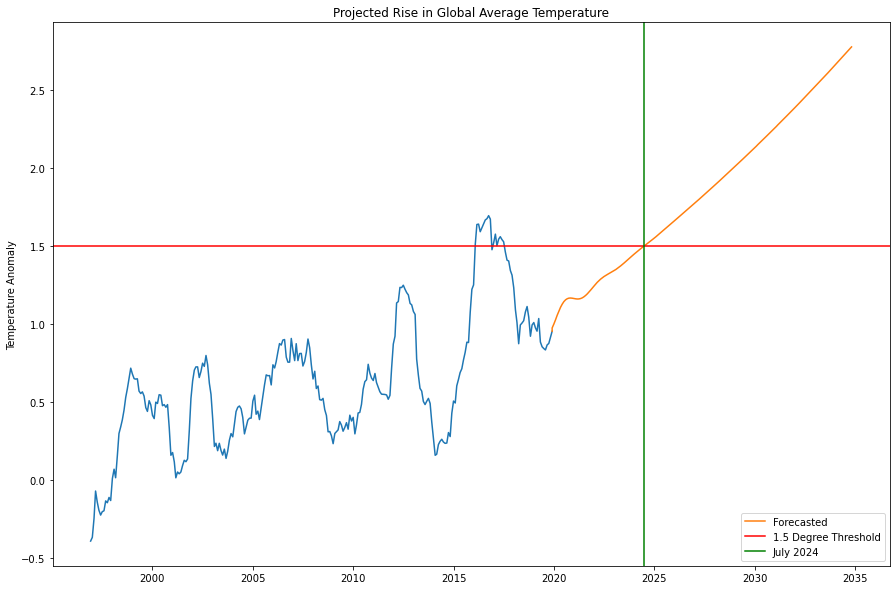

In [64]:
forecast = model_fit.forecast(180)

forecast_period = len(forecast[0])
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

future_months = pd.DataFrame(date_range, columns = ['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]

plt.figure(figsize=(15,10))
plt.plot(y_rolled)
plt.plot(np.exp(y_log['Dec 2019'].append(future_months['Prediction']))-2, label='Forecasted')

#Line for 1.5 threshold
plt.axhline(y= 1.5, color='r', linestyle='-', label='1.5 Degree Threshold')
plt.axvline(x= 19900, color='g', linestyle='-', label='July 2024')

plt.ylabel('Temperature Anomaly')
plt.title('Projected Rise in Global Average Temperature')
plt.legend(loc='lower right')
plt.show()

In [29]:
pred = pd.DataFrame(np.exp(future_months['Prediction'])-2)
#pred[round(pred.Prediction, ndigits=1) == round((1.5 + (y_rolled['Apr 2016'].values))[0], ndigits=1)]
pred[round(pred.Prediction, ndigits=1) == 1.5]

,Prediction
Month,
2024-02-01,1.458449
2024-03-01,1.467370
2024-04-01,1.476082
2024-05-01,1.484613
2024-06-01,1.493007
2024-07-01,1.501313
2024-08-01,1.509584
2024-09-01,1.517871
2024-10-01,1.526220


According to the forecasted model, the average temperature will consistently reach/exceed the 1.5 temperature threshold by around July 2024.

**Visualizing all ARIMA models**

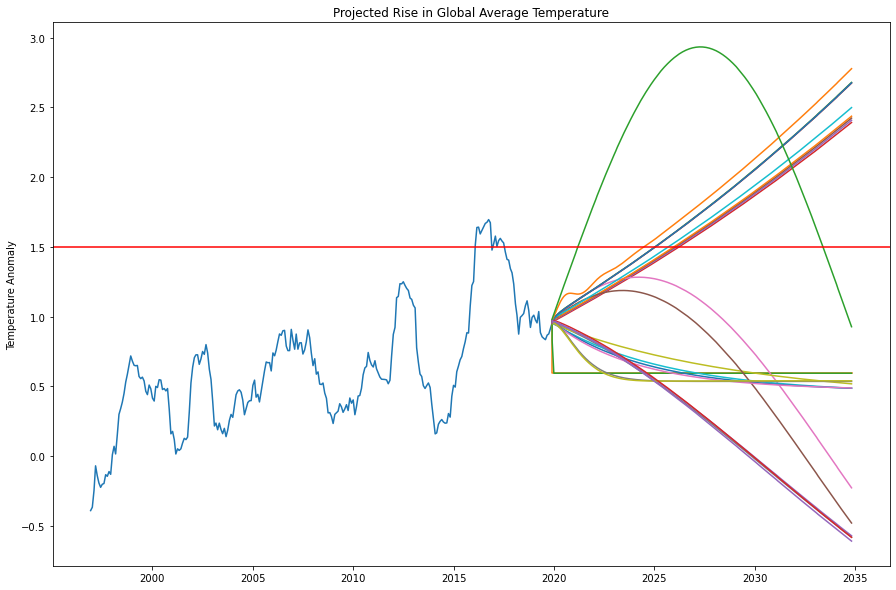

In [30]:
plt.figure(figsize=(15,10))
plt.plot(y_rolled)


for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(y_log, order=(p,d,q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(180)
                
                    forecast_period = len(forecast[0])
                    date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
                                           freq='MS').strftime("%Y-%m-%d").tolist()

                    future_months = pd.DataFrame(date_range, columns = ['Month'])
                    future_months['Month'] = pd.to_datetime(future_months['Month'])
                    future_months.set_index('Month', inplace = True)
                    future_months['Prediction'] = forecast[0]
                    
                    if (p==0 and d==2 and q==0) or (p==1 and d==2 and q==0):
                        pass
                    else:
                        plt.plot(np.exp(y_log['Dec 2019'].append(future_months['Prediction']))-2)
                except:
                    continue

#Line for 1.5 threshold
plt.axhline(y= 1.5, color='r', linestyle='-')
plt.ylabel('Temperature Anomaly')
plt.title('Projected Rise in Global Average Temperature')
plt.show()

**ARIMA(p,0,d)**

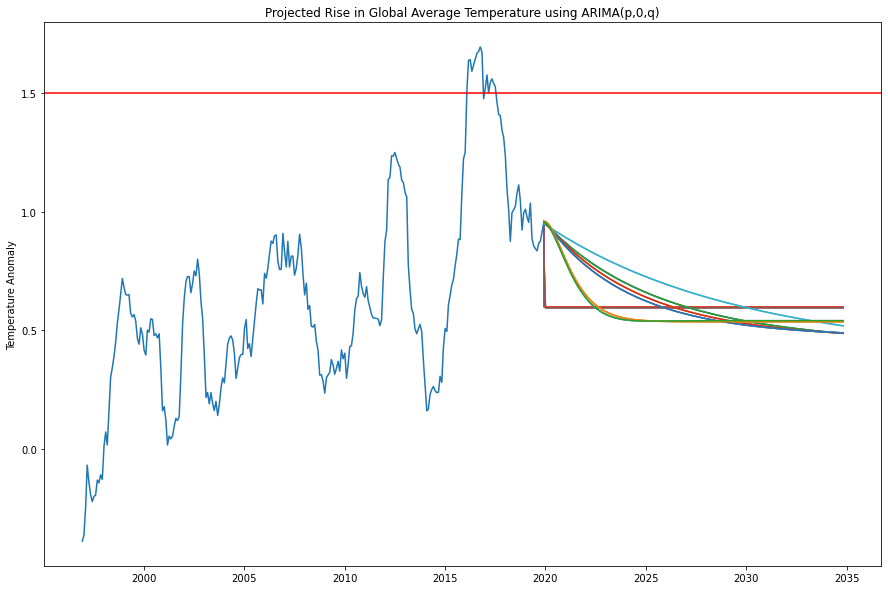

In [31]:
plt.figure(figsize=(15,10))
plt.plot(y_rolled)


for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(y_log, order=(p,0,q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(180)
                
                    forecast_period = len(forecast[0])
                    date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
                                           freq='MS').strftime("%Y-%m-%d").tolist()

                    future_months = pd.DataFrame(date_range, columns = ['Month'])
                    future_months['Month'] = pd.to_datetime(future_months['Month'])
                    future_months.set_index('Month', inplace = True)
                    future_months['Prediction'] = forecast[0]
                    
                    if (p==0 and d==2 and q==0) or (p==1 and d==2 and q==0):
                        pass
                    else:
                        plt.plot(np.exp(y_log['Dec 2019'].append(future_months['Prediction']))-2)
                except:
                    continue

#Line for 1.5 threshold
plt.axhline(y= 1.5, color='r', linestyle='-')
plt.ylabel('Temperature Anomaly')
plt.title('Projected Rise in Global Average Temperature using ARIMA(p,0,q)')
plt.show()

**ARIMA(p,1,d)**

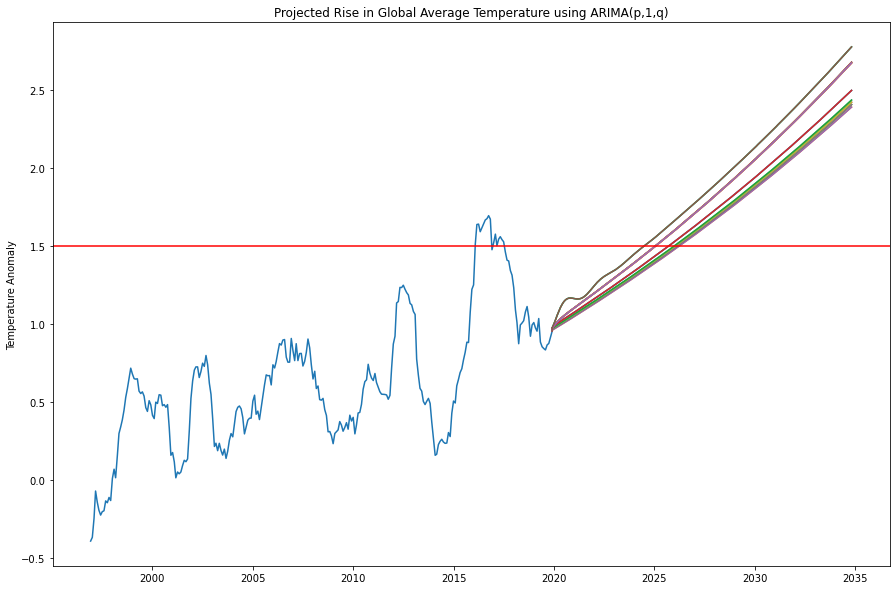

In [32]:
plt.figure(figsize=(15,10))
plt.plot(y_rolled)


for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(y_log, order=(p,1,q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(180)
                
                    forecast_period = len(forecast[0])
                    date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
                                           freq='MS').strftime("%Y-%m-%d").tolist()

                    future_months = pd.DataFrame(date_range, columns = ['Month'])
                    future_months['Month'] = pd.to_datetime(future_months['Month'])
                    future_months.set_index('Month', inplace = True)
                    future_months['Prediction'] = forecast[0]
                    
                    if (p==0 and d==2 and q==0) or (p==1 and d==2 and q==0):
                        pass
                    else:
                        plt.plot(np.exp(y_log['Dec 2019'].append(future_months['Prediction']))-2)
                except:
                    continue

#Line for 1.5 threshold
plt.axhline(y= 1.5, color='r', linestyle='-')
plt.ylabel('Temperature Anomaly')
plt.title('Projected Rise in Global Average Temperature using ARIMA(p,1,q)')
plt.show()

**ARIMA(p,2,d)**

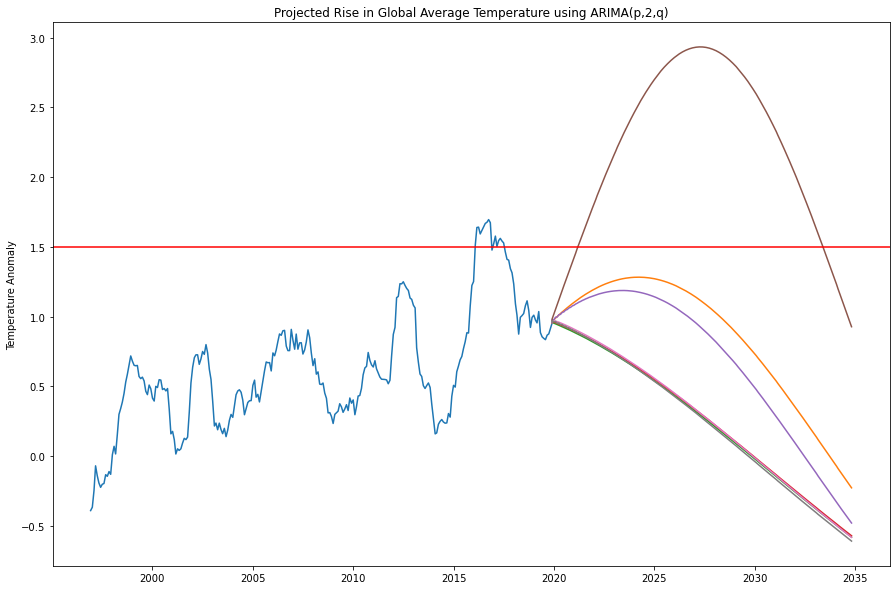

In [33]:
plt.figure(figsize=(15,10))
plt.plot(y_rolled)

d_values_2 = [x for x in range(2, 3)]


for p in p_values:
        for d in d_values_2:
            for q in q_values:
                try:
                    model = ARIMA(y_log, order=(p,d,q))
                    model_fit = model.fit()
                    forecast = model_fit.forecast(180)
                
                    forecast_period = len(forecast[0])
                    date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
                                           freq='MS').strftime("%Y-%m-%d").tolist()

                    future_months = pd.DataFrame(date_range, columns = ['Month'])
                    future_months['Month'] = pd.to_datetime(future_months['Month'])
                    future_months.set_index('Month', inplace = True)
                    future_months['Prediction'] = forecast[0]
                    
                    if (p==0 and d==2 and q==0) or (p==1 and d==2 and q==0):
                        pass
                    else:
                        plt.plot(np.exp(y_log['Dec 2019'].append(future_months['Prediction']))-2)
                except:
                    continue

#Line for 1.5 threshold
plt.axhline(y= 1.5, color='r', linestyle='-')
plt.ylabel('Temperature Anomaly')
plt.title('Projected Rise in Global Average Temperature using ARIMA(p,2,q)')
plt.show()

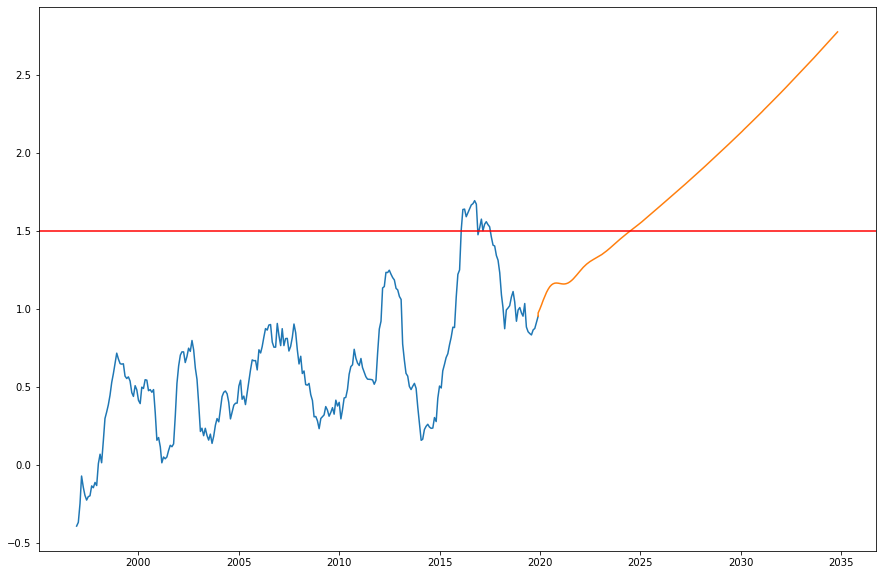

In [34]:
model = ARIMA(y_log, order=(2,1,2))
model_fit = model.fit()
forecast = model_fit.forecast(180)

forecast_period = len(forecast[0])
date_range = pd.date_range(y_log.index[-1], periods = forecast_period, 
              freq='MS').strftime("%Y-%m-%d").tolist()

future_months = pd.DataFrame(date_range, columns = ['Month'])
future_months['Month'] = pd.to_datetime(future_months['Month'])
future_months.set_index('Month', inplace = True)
future_months['Prediction'] = forecast[0]

plt.figure(figsize=(15,10))
plt.plot(y_rolled)
plt.plot(np.exp(y_log['Dec 2019'].append(future_months['Prediction']))-2)

#Line for 1.5 threshold
plt.axhline(y= 1.5, color='r', linestyle='-')
#plt.axhline(y= 1.5 + (y_rolled['Apr 2016'].values), color='r', linestyle='-')
#plt.axhline(y= (y_rolled['Apr 2016'].values), color='g', linestyle='-')


plt.show()

In [35]:
def plot_eval_metrics(data, p_values, d_values, q_values):
    rmse_list = []
    mape_list = []
    mae_list = []
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    rmse = eval_rmse(data, order)
                    mape = eval_mape(data, order)
                    mae = eval_mae(data, order)
                    
                    rmse_list.append(rmse)
                    mape_list.append(mape)
                    mae_list.append(mae)
                    
                    print('ARIMA%s' % (order))
                    
                except:
                    continue
    
    return rmse_list, mape_list, mae_list

In [36]:
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

rmse_list = []
mape_list = []
mae_list = []
order_list = []

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            
            try:
                rmse = eval_rmse(y_log, order)
                mape = eval_mape(y_log, order)
                mae = eval_mae(y_log, order)
                current_order = str(order)

                rmse_list.append(rmse)
                mape_list.append(mape)
                mae_list.append(mae)
                order_list.append(current_order)
            
                print(current_order)
            
            except:
                    continue

print('End of For Loop!')

(0, 0, 0)
(0, 0, 1)
(0, 1, 0)
(0, 1, 1)
(0, 1, 2)
(0, 2, 0)
(0, 2, 1)
(0, 2, 2)
(1, 0, 0)
(1, 0, 1)
(1, 0, 2)
(1, 1, 0)
(1, 1, 1)
(1, 1, 2)
(1, 2, 0)
(1, 2, 1)
(1, 2, 2)
(2, 0, 0)
(2, 0, 1)
(2, 0, 2)
(2, 1, 0)
(2, 1, 1)
(2, 1, 2)
(2, 2, 0)
(2, 2, 1)
(2, 2, 2)
End of For Loop!


In [37]:
metrics = pd.DataFrame(list(zip(order_list, rmse_list, mape_list, mae_list)))
metrics.rename(columns={0:'Order', 1:'RMSE', 2:'MAPE', 3:'MAE'}, inplace=True)
metrics

,Order,RMSE,MAPE,MAE
0,"(0, 0, 0)",0.249485,0.189817,0.226929
1,"(0, 0, 1)",0.128621,0.097004,0.115909
2,"(0, 1, 0)",0.025096,0.015903,0.018194
3,"(0, 1, 1)",0.024391,0.015112,0.017289
4,"(0, 1, 2)",0.024400,0.015077,0.017308
5,"(0, 2, 0)",0.030503,0.018733,0.021603
6,"(0, 2, 1)",0.024066,0.015570,0.017994
7,"(0, 2, 2)",0.026055,0.016552,0.019078
8,"(1, 0, 0)",0.025420,0.016446,0.018813
9,"(1, 0, 1)",0.024795,0.015350,0.017552


In [38]:
metrics_rmse = metrics.sort_values(by='RMSE')
metrics_rmse = metrics_rmse[metrics_rmse.RMSE <= 0.1]
metrics_rmse

,Order,RMSE,MAPE,MAE
22,"(2, 1, 2)",0.023012,0.014426,0.016647
12,"(1, 1, 1)",0.023687,0.014647,0.016857
21,"(2, 1, 1)",0.023701,0.014564,0.016760
13,"(1, 1, 2)",0.023706,0.014533,0.016723
6,"(0, 2, 1)",0.024066,0.015570,0.017994
20,"(2, 1, 0)",0.024112,0.014990,0.017252
16,"(1, 2, 2)",0.024252,0.015499,0.017800
11,"(1, 1, 0)",0.024261,0.014961,0.017158
24,"(2, 2, 1)",0.024314,0.015242,0.017516
3,"(0, 1, 1)",0.024391,0.015112,0.017289


Text(0.5, 1.0, 'ARIMA Models Sorted By RMSE')

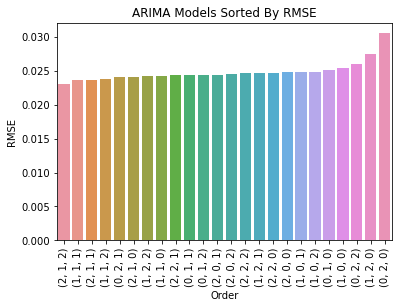

In [42]:
sns.barplot(x='Order', y='RMSE', data=metrics_rmse)
plt.xticks(rotation='vertical')
plt.title('ARIMA Models Sorted By RMSE')

Text(0.5, 1.0, 'ARIMA Models Sorted By MAPE')

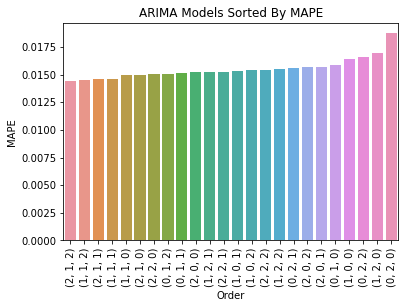

In [43]:
metrics_mape = metrics.sort_values(by='MAPE')
metrics_mape = metrics_mape[metrics_mape.MAPE <= 0.09]

sns.barplot(x='Order', y='MAPE', data=metrics_mape)
plt.xticks(rotation='vertical')
plt.title('ARIMA Models Sorted By MAPE')

Text(0.5, 1.0, 'ARIMA Models Sorted By MAE')

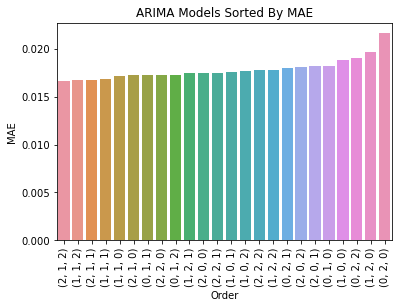

In [44]:
metrics_mae = metrics.sort_values(by='MAE')
metrics_mae = metrics_mae[metrics_mae.MAE <= 0.09]

sns.barplot(x='Order', y='MAE', data=metrics_mae)
plt.xticks(rotation='vertical')
plt.title('ARIMA Models Sorted By MAE')